# Importing Libs

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings as w
w.filterwarnings('ignore')

In [5]:
df=pd.read_csv('/kaggle/input/sales-forecasting/train.csv')

In [6]:
df['Order Date']=pd.to_datetime(df['Order Date'],format='%d/%m/%Y')
df['Ship Date']=pd.to_datetime(df['Ship Date'],format='%d/%m/%Y')
df['Processing Time']=(df['Ship Date']-df['Order Date']).dt.days

In [7]:
df['Postal Code'] = df['Postal Code'].fillna(5401)

# EDA

## Customer Segment Distribution

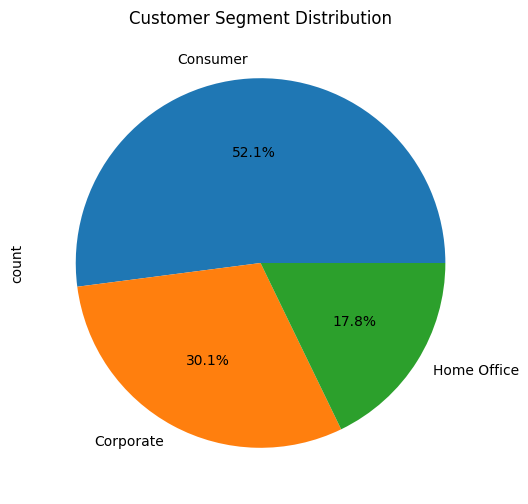

In [8]:
df['Segment'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(6,6))
plt.title("Customer Segment Distribution")
plt.show()

## Monthly Sales Trend

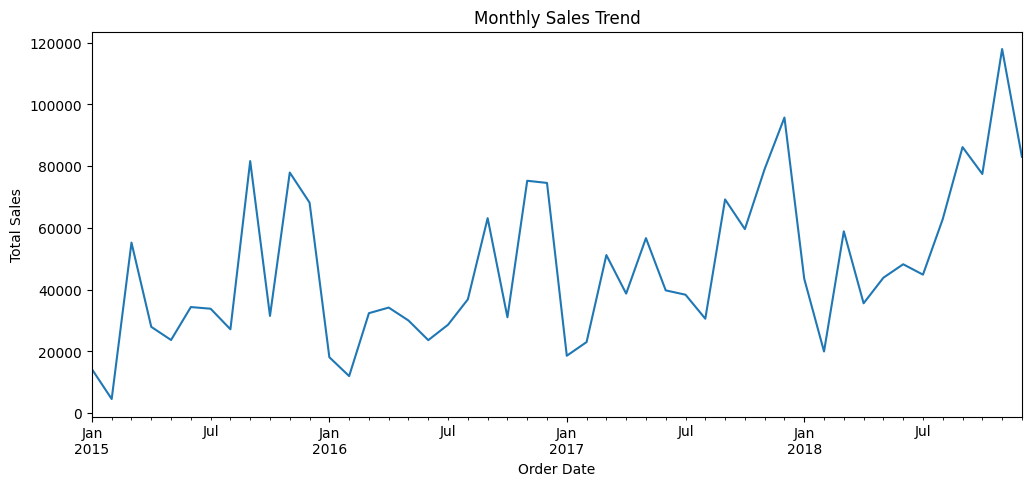

In [10]:
df.set_index('Order Date')['Sales'].resample('M').sum().plot(figsize=(12,5))
plt.title("Monthly Sales Trend")
plt.ylabel("Total Sales")
plt.savefig('trends.png')
plt.show()

## Total Sales by Region

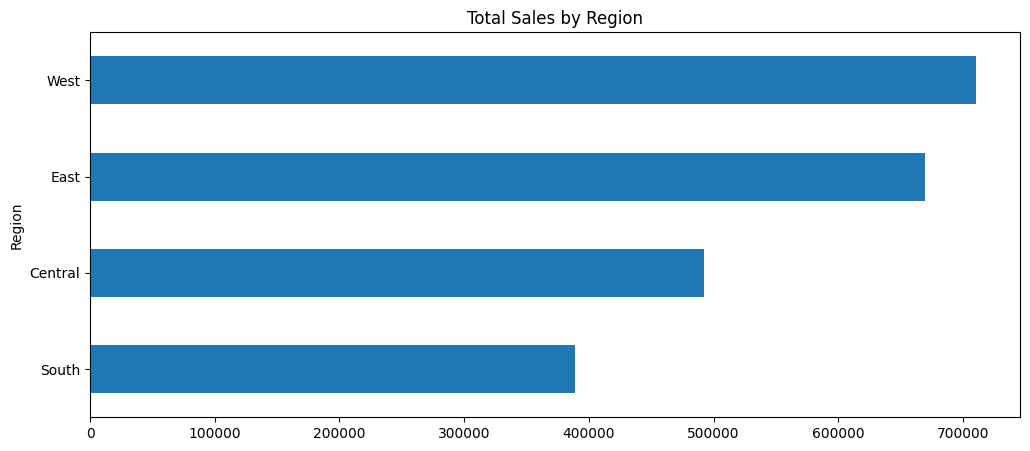

In [11]:
plt.figure(figsize=(12,5))
df.groupby('Region')['Sales'].sum().sort_values().plot(kind='barh')
plt.title("Total Sales by Region")
plt.show()

## Time Taken by different Ship modes

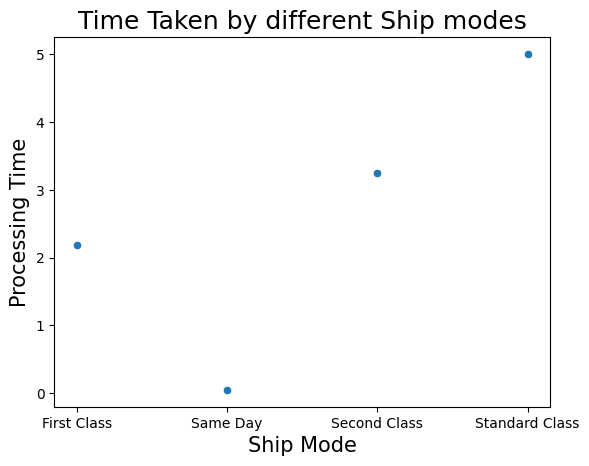

In [12]:
mean_delivery_time=df.groupby(['Ship Mode'])['Processing Time'].mean().reset_index()
sns.scatterplot(x='Ship Mode',y='Processing Time',data=mean_delivery_time)
plt.xlabel("Ship Mode",fontsize=15)
plt.ylabel("Processing Time",fontsize=15)
plt.title("Time Taken by different Ship modes", fontsize=18)
plt.show()

## Most Valuable Customers

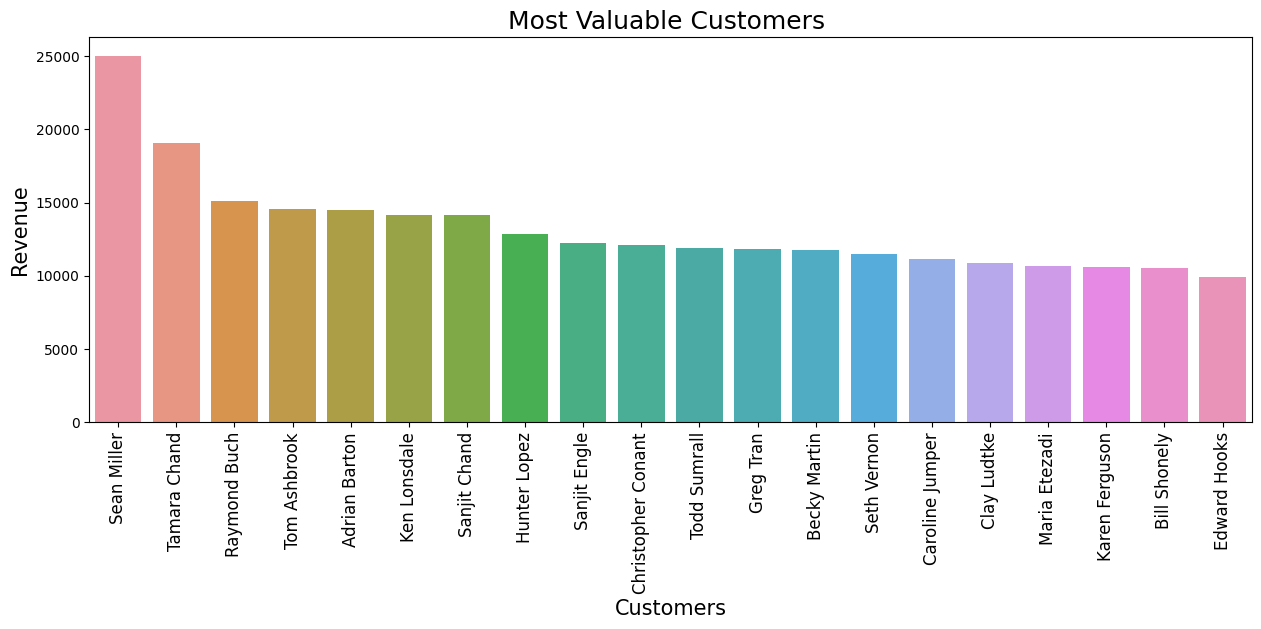

In [13]:
df_no_date = df.drop(columns=df.select_dtypes(include='datetime').columns)
top_costomer=df_no_date.groupby(['Customer Name']).sum().sort_values(('Sales'),ascending=False).head(20)
top_costomer=top_costomer.reset_index()
plt.figure(figsize = (15,5))
sns.barplot(x='Customer Name',y='Sales',data=top_costomer)
plt.xlabel("Customers",fontsize=15)
plt.ylabel("Revenue",fontsize=15)
plt.xticks(fontsize=12, rotation=90)
plt.title("Most Valuable Customers ", fontsize=18)
plt.show()

## Sub-Categories Distribution per Category

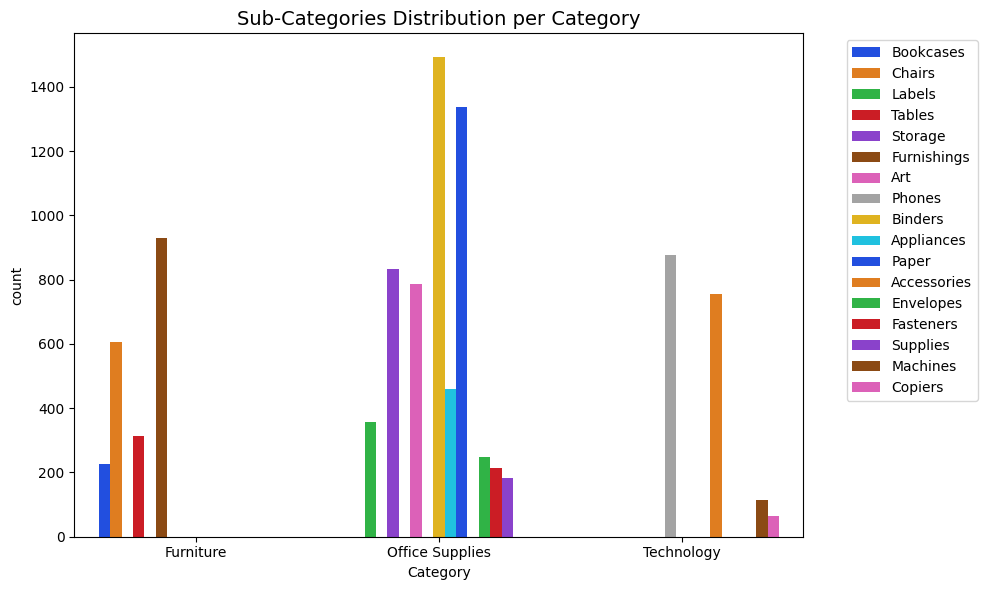

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Category', hue='Sub-Category', palette='bright')
plt.title("Sub-Categories Distribution per Category", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Total Sales by Region

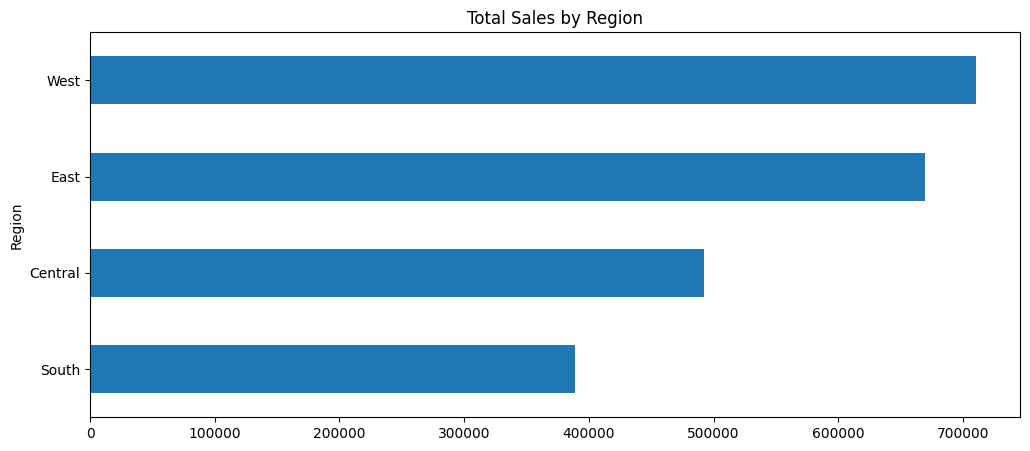

In [15]:
plt.figure(figsize=(12,5))
df.groupby('Region')['Sales'].sum().sort_values().plot(kind='barh')
plt.title("Total Sales by Region")
plt.show()

## Top 10 Cities by Sales

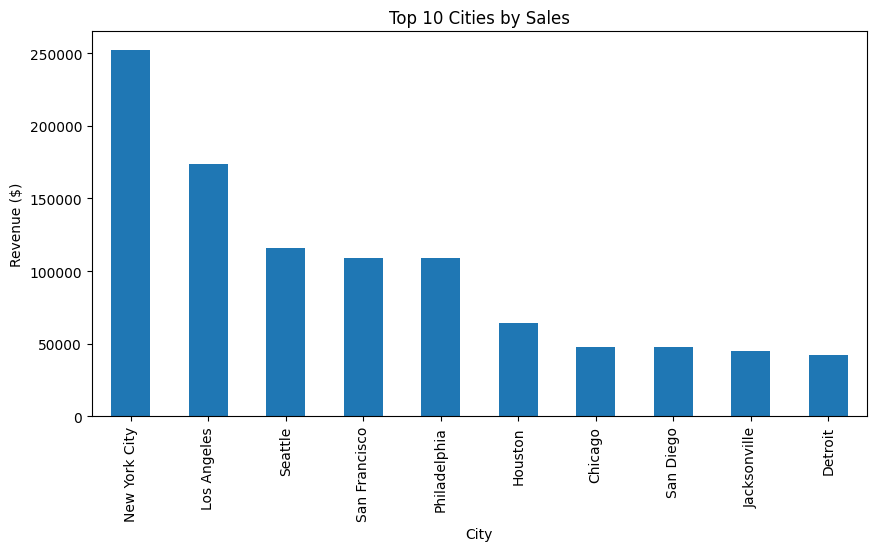

In [16]:
top_cities = df.groupby('City')['Sales'].sum().sort_values(ascending=False).head(10)
top_cities.plot(kind='bar', figsize=(10,5))
plt.title("Top 10 Cities by Sales")
plt.ylabel("Revenue ($)")
plt.xticks(rotation=90)
plt.show()

## Corr Matrix

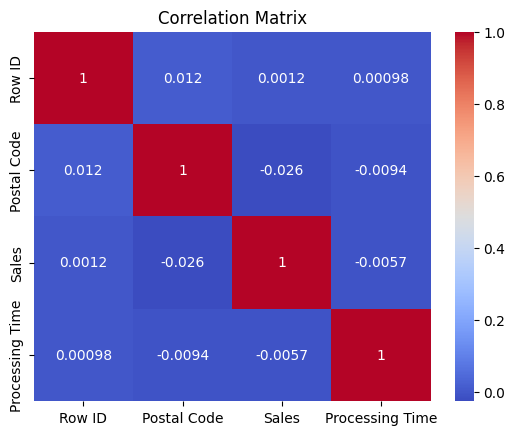

In [18]:
numeric_df = df.select_dtypes(include=['int64','float64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.savefig('heatmap.png')
plt.show()

# Model

## Outliers removal

In [19]:
q1 = df['Sales'].quantile(0.01)
q99 = df['Sales'].quantile(0.99)
df = df[(df['Sales'] >= q1) & (df['Sales'] <= q99)]


## Model Linear Reg

R² Score     : 0.3164
MAE          : 110.07
MSE          : 67796.89


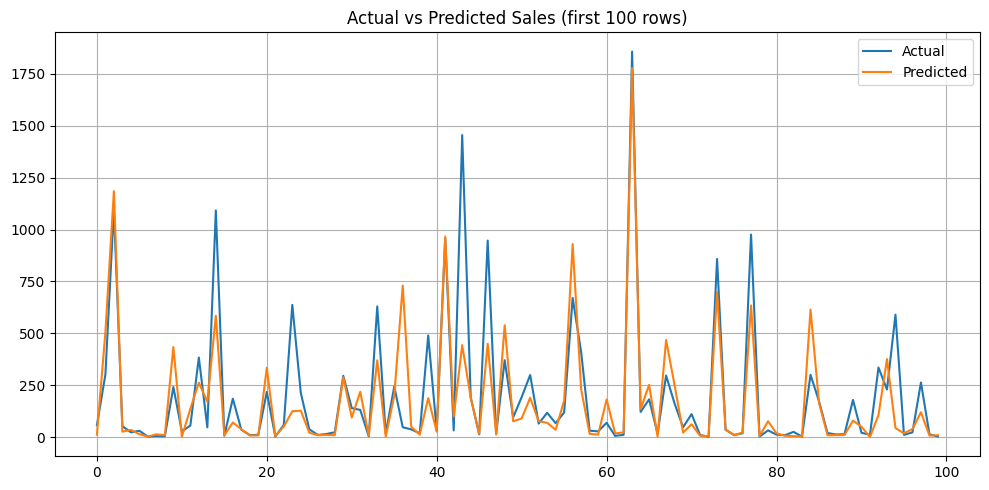

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import os

X = df.drop(columns=['Row ID', 'Order ID', 'Customer ID', 'Product ID', 'Sales'])
y = df['Sales']
y = np.log1p(y)

if 'Order Date' in X.columns:
    X['Order Date'] = pd.to_datetime(X['Order Date'])
    X['Order_Month'] = X['Order Date'].dt.month
    X['Order_Year'] = X['Order Date'].dt.year
    X.drop(columns='Order Date', inplace=True)

num_cols = X.select_dtypes(include='number').columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

model = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', LinearRegression())
])

model.fit(X_train, y_train)
pred = model.predict(X_test)

y_test = np.expm1(y_test)
pred = np.expm1(pred)

r2 = r2_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)

print(f"R² Score     : {r2:.4f}")
print(f"MAE          : {mae:.2f}")
print(f"MSE          : {mse:.2f}")

os.makedirs('outputs', exist_ok=True)

plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(pred[:100], label='Predicted')
plt.title("Actual vs Predicted Sales (first 100 rows)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('outputs/actual_vs_predicted.png')
plt.show()
